#### Introduction
Simple Colour paletter problem has been used to demostrate dimensional reduction using SOM. Here the input is 3D vector which has been compressed to 2D (generally SOM are used to compress to two or three dimensions). This is represented on the SOM grid using colours to each 3D input and associating with approriate neuron (which activates the neuron the most) on 2D grid. This should get clear by looking at the MNIST handwritten problem or Simon Haykin Neural Network textbook problem on SOM (contextual map).

In [9]:
# Import Required Libraries
import numpy 
from matplotlib import pyplot as plt
from copy import deepcopy
from matplotlib import patches as patches

#### Data
Generating color data. Which will be used for SOM. Raw data is represented by matrix $X$ which is 100x3 dimension, with each row representing RGB values. SOM Neural Network contains 2D 10x10 grid i.e. 100 neurons; weight matrix $W$ is 100x3 dimension and bias terms are zero. Also weight matirx must have  Matrix $Index$ of 100x2 dimension associates neurons with 2D 10x10 grid. Activation function is linear activation function. 

SOM network grid and Raw data shape can be changed by changing the values in the Raw_Data_Shape and SOM_Network_Shape variables. 

SOM trains very well when data is normalsied. Also, the best-matching criterion, based on maximizing the inner product $\textbf{w}_{j}^{T}\textbf{x}$ is mathematically equivalent to minimizing the Euclidean distance between the vectors $\textbf{x}$ and $\textbf{w}_{j}$, provided that $\textbf{w}_{j}$ has unit length for all $j$. Hence normalise the raw data and initial guess weights to have unit lenght.

In [10]:
# Generate Data
Raw_Data_Shape = numpy.array([100, 3])
SOM_Network_Shape = numpy.array([20, 20])
X = numpy.random.randint(0, 256, (Raw_Data_Shape[0], Raw_Data_Shape[1]))
X_Norm = X/numpy.linalg.norm(X, axis=1).reshape(Raw_Data_Shape[0], 1)
W_Initial_Guess = numpy.random.uniform(0, 1, (SOM_Network_Shape[0]*SOM_Network_Shape[1], Raw_Data_Shape[1]))
W_Initial_Guess_Norm = W_Initial_Guess/numpy.linalg.norm(W_Initial_Guess, axis=1).reshape(SOM_Network_Shape[0]*SOM_Network_Shape[1], 1)
Index = numpy.mgrid[0:SOM_Network_Shape[0],0:SOM_Network_Shape[1]].reshape(2, SOM_Network_Shape[0]*SOM_Network_Shape[1]).T

#### Parameter Selection
1 - Learning Rate: must not be allowed to decrease to zero otherwise, it is possible for the network to get stuck in a metastable state. A metastable state belongs to a configuration of the feature map with a topological defect.The exponential decay of learning rate guarantees against the possibility of metastable states. Learning Rate Decay:
\begin{align*}
    \eta(epochs) = \eta_{0} \exp\left(\frac{-epochs}{\tau}\right) 
\end{align*}
These desirable values are satisfied by the following choices in the formula $\eta_{0}$ = 0.1 and $\tau$ = 1000

2 - Varinace of the Gaussian neighbourhood function: Assuming the use of a two-dimensional lattice of neurons for the discrete map, set the initial size $\sigma_{0}$ of the neighborhood function equal to the “radius” of the lattice. Correspondingly, set the time constant $\tau$ as $\frac{1000}{log(\sigma_{0})}$. Variance Decay:
\begin{align*}
    \sigma(epochs) = \sigma_{0} \exp\left(\frac{-epochs}{\tau}\right) 
\end{align*}

3 - Maximum Epochs: Adaptation of the synaptic weights in the SOM network can be decomposed into two phases ordering/self-ordering phase followed by a convergence phase. It is during this first phase of the adaptive process that the topological ordering of the weight vectors takes place. The ordering phase may take as many as 1,000 epochs of the SOM algorithm, and possibly even more. Second phase of the adaptive process is needed to finetune the feature map and therefore provide an accurate statistical quantification of the input space. Moreover, the number of iterations needed for convergence depends strongly on the dimensionality of the input space. As a general rule, the number of iterations constituting the convergence phase must be at least 500 times the number of neurons in the network. Thus, the convergence phase may have to go on for thousands, and possibly even tens of thousands, of iterations.

In [11]:
# Parameters 
Epoch = 0 
Max_Epoch = 55000
eta_0 = 0.1
eta_time_const = 1000
sigma_0 = numpy.max(SOM_Network_Shape) * 0.5
sigma_time_const = 1000/numpy.log10(sigma_0)

In [12]:
# Required Functions
def winning_neuron(x, W):
    # Also called as Best Matching Neuron/Best Matching Unit (BMU)
    return numpy.argmin(numpy.linalg.norm(x - W, axis=1))

def update_weights(lr, var, x, W, Grid):
    i = winning_neuron(x, W)
    d = numpy.square(numpy.linalg.norm(Grid - Grid[i], axis=1))
    # Topological Neighbourhood Function
    h = numpy.exp(-d/(2 * var * var))
    W = W + lr * h[:, numpy.newaxis] * (x - W)
    return W

def decay_learning_rate(eta_initial, epoch, time_const):
    return eta_initial * numpy.exp(-epoch/time_const)

def decay_variance(sigma_initial, epoch, time_const):
    return sigma_initial * numpy.exp(-epoch/time_const)

In [13]:
# Main Loop
W_new = deepcopy(W_Initial_Guess_Norm)
eta = deepcopy(eta_0)
sigma = deepcopy(sigma_0)
while Epoch <= Max_Epoch:
    # Update Weights
    i = numpy.random.randint(0, Raw_Data_Shape[0])
    W_new = update_weights(eta, sigma, X_Norm[i], W_new, Index)
    # Print
#     print('Epoch: ', Epoch, ' Learning Rate: ', eta, ' Varinance: ', sigma, '\n')
    # Next...
    eta = decay_learning_rate(eta_0, Epoch, eta_time_const)
    sigma = decay_variance(sigma_0, Epoch, sigma_time_const)
    Epoch += 1
print('Optimal Weights Reached!!!')

Optimal Weights Reached!!!


#### Test
Here we show all the inputs to the SOM network and see which neuron gets activated and place our input over there. There can be some overlaps between inputs hence we find places where there are no inputs place and we find which input is closest and place there. 

In [14]:
# Test
W_final = deepcopy(W_new)
Colour = numpy.zeros((SOM_Network_Shape[0]*SOM_Network_Shape[1], 3))
for i in range(0, Raw_Data_Shape[0]):
    bmu = winning_neuron(X_Norm[i], W_final)
    Colour[bmu] = X_Norm[i]

Zero_Pos = numpy.where(~Colour.any(axis=1))[0] # numpy.where(Colour[:, 0] == 0)[0] 
for i in range(0, Zero_Pos.size):
    temp = numpy.array([])
    for j in range(0, Raw_Data_Shape[0]):
        a = numpy.linalg.norm(X_Norm[j] - W_final[Zero_Pos[i]])
        temp = numpy.concatenate((temp, [a]), axis=0)
    bmu = numpy.argmin(temp)
    Colour[Zero_Pos[i]] = X_Norm[bmu]

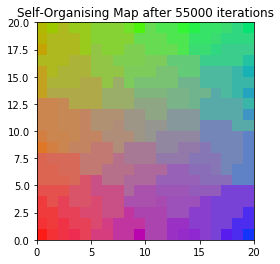

In [15]:
# Plot
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, SOM_Network_Shape[0]))
ax.set_ylim((0, SOM_Network_Shape[1]))
ax.set_title('Self-Organising Map after %d iterations' % Max_Epoch)

# plot the rectangles
i = 0
for x in range(0, SOM_Network_Shape[0]):
    for y in range(0, SOM_Network_Shape[1]):
        ax.add_patch(patches.Rectangle((x, y), 1, 1, facecolor=Colour[i], edgecolor='none'))
        i += 1
plt.savefig('Self-Organising Map.pdf')
plt.show()